Running simulations for both time periods...


Overall Progress:   0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-1-63eb13fc8fd5>:18: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
<ipython-input-1-63eb13fc8fd5>:22: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
Overall Progress: 100%|██████████| 2/2 [08:44<00:00, 262.29s/it]


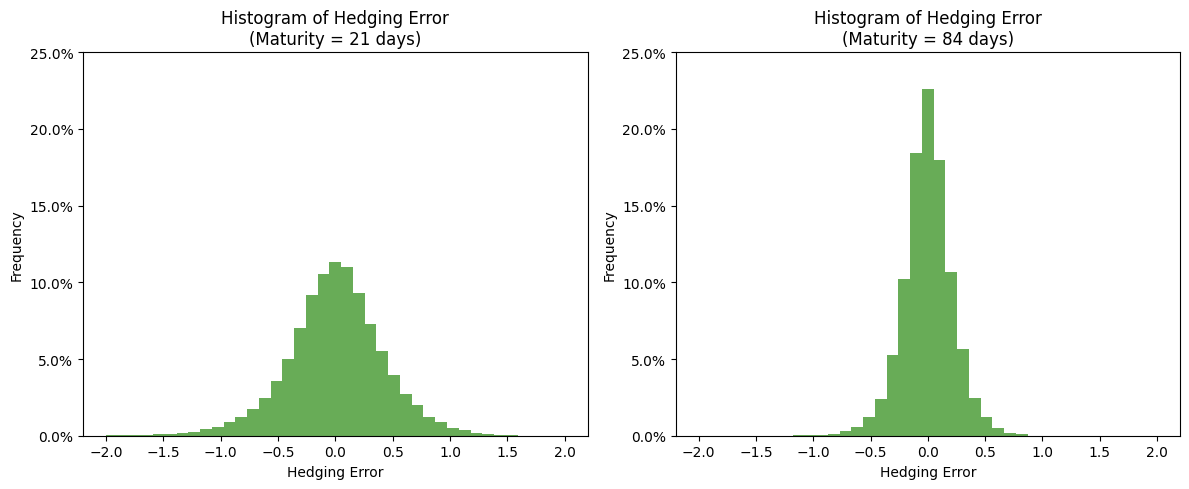

   Days      Mean  Standard Deviation  Std of Option Premium (%)
0    21  0.000380            0.427623                  17.022761
1    84 -0.000529            0.215866                   8.593156

Analyzing impact of volatility...


Processing volatilities:   0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-1-63eb13fc8fd5>:18: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
<ipython-input-1-63eb13fc8fd5>:22: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
Processing volatilities: 100%|██████████| 5/5 [43:40<00:00, 524.10s/it]
<ipython-input-1-63eb13fc8fd5>:198: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(errors_21, labels=[f'σ={vol:.1f}' for vol in volatilities],
<ipython-input-1-63eb13fc8fd5>:206: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(errors_84, labels=[f'σ={vol:.1f}

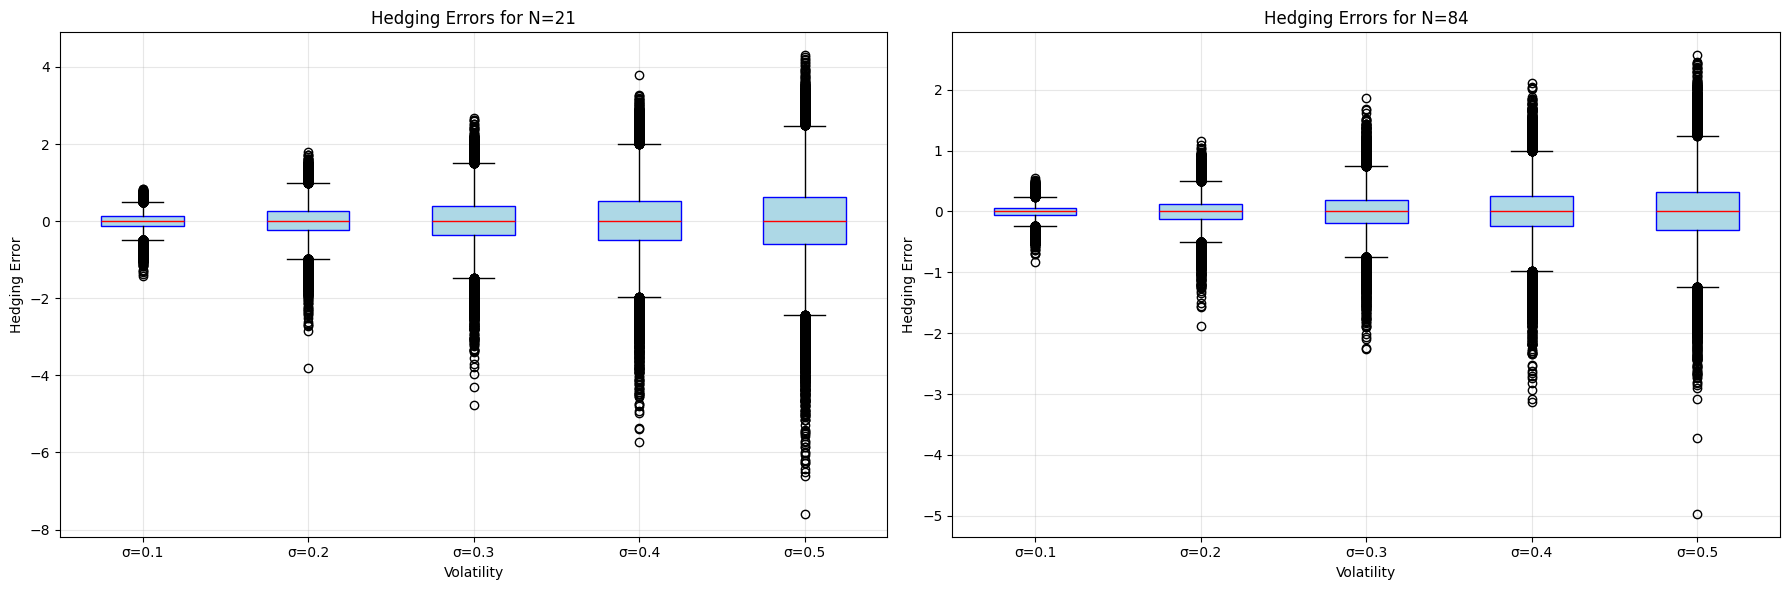

<ipython-input-1-63eb13fc8fd5>:120: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
<ipython-input-1-63eb13fc8fd5>:124: RuntimeWarning: invalid value encountered in scalar divide
  gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
<ipython-input-1-63eb13fc8fd5>:125: RuntimeWarning: invalid value encountered in scalar divide
  theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2))


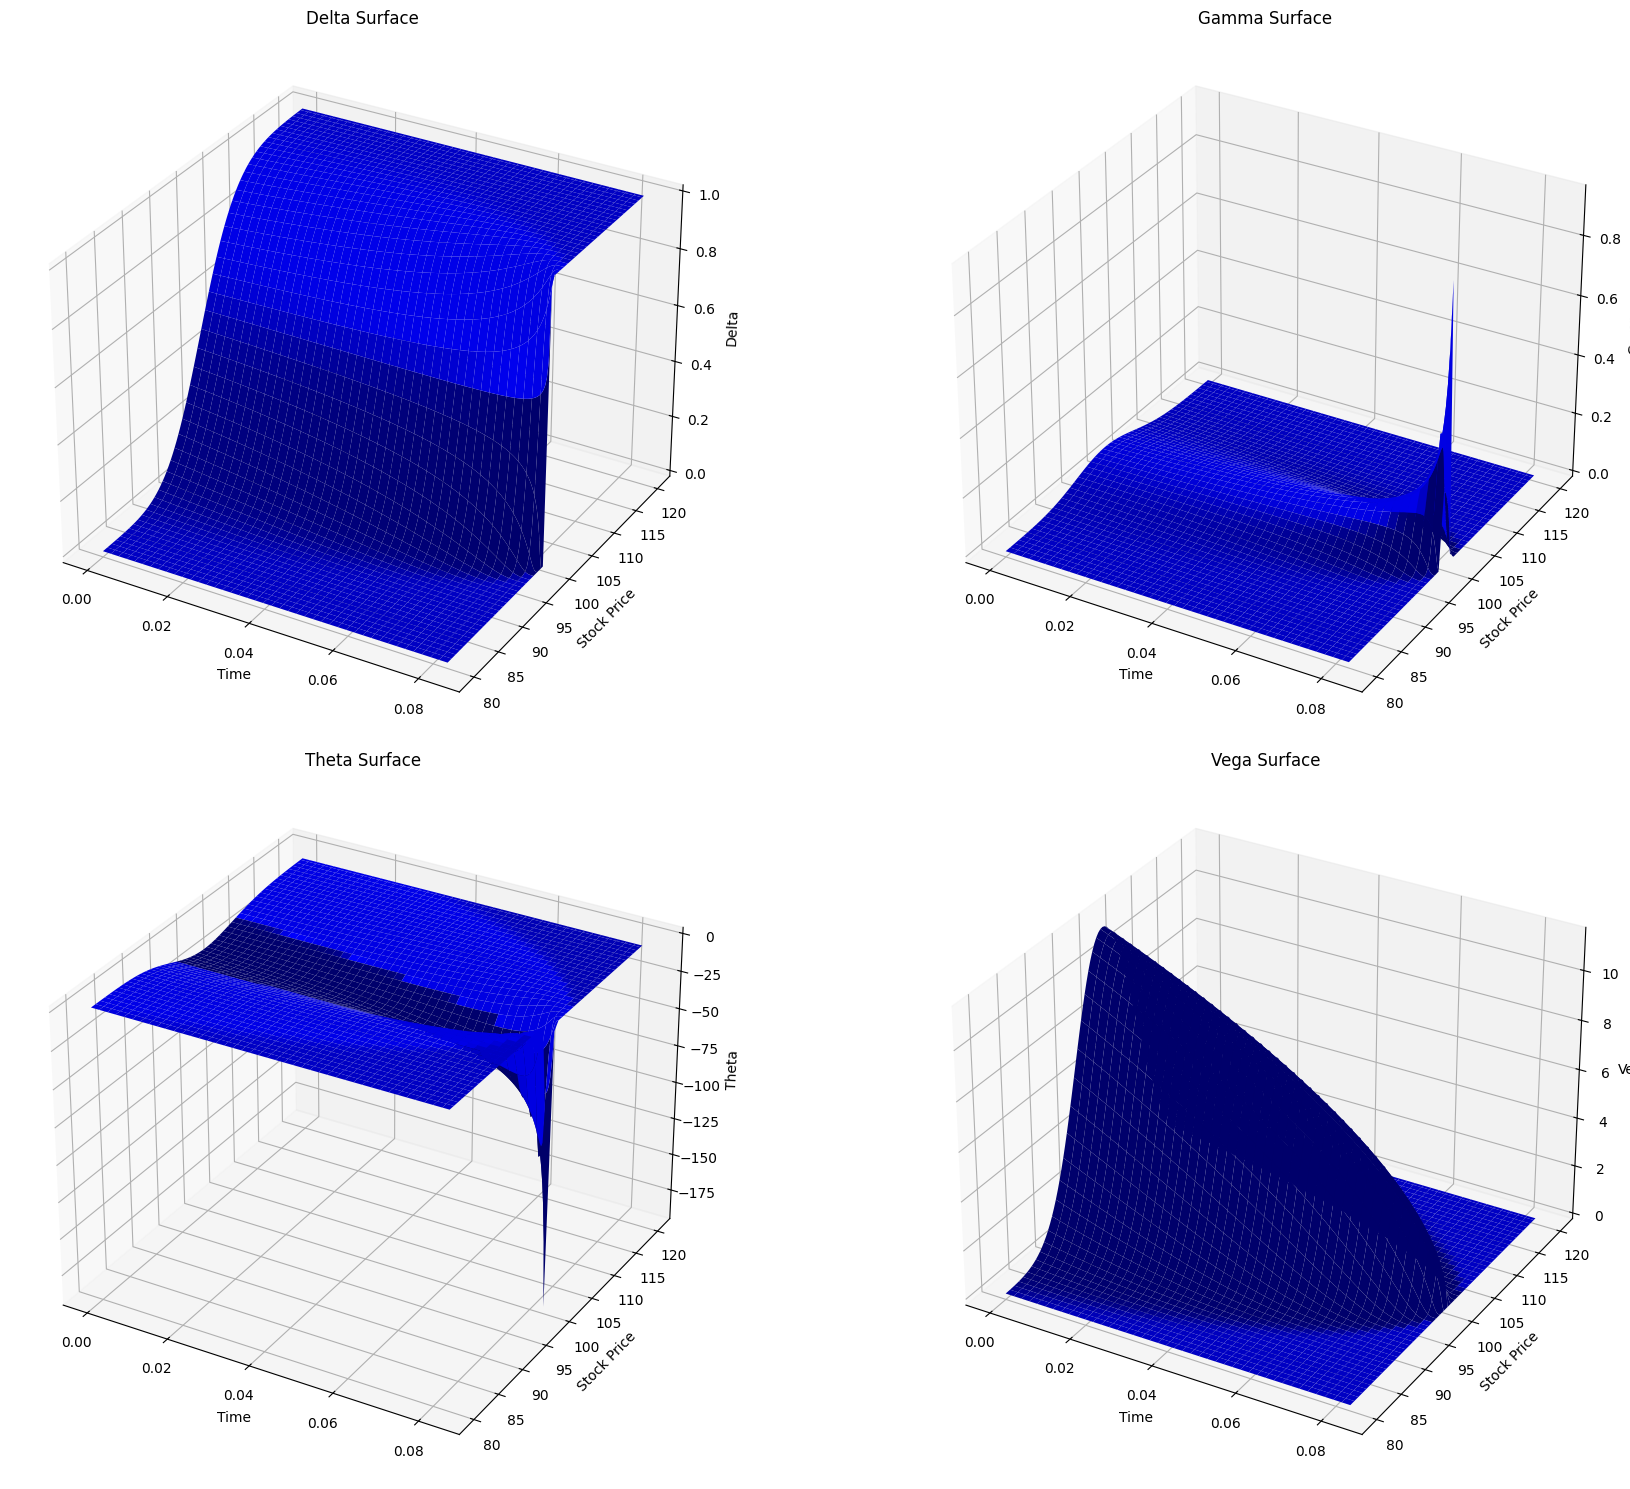

In [ ]:
INTEREST_RATE = 0.05
INITIAL_STOCK_PRICE = 100.0
STRIKE_PRICE = 100.0
VOLATILITY = 0.2
NUM_PATHS = 50000
MATURITY = 1/12
TRADING_DAYS = 252

from scipy.stats import norm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from matplotlib.ticker import PercentFormatter
from tqdm import tqdm 

def phi(S, K, r, sigma, T):
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

def psi_Bt(S, K, r, sigma, T):
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return -K * np.exp(-r * T) * norm.cdf(d2)

def simulate_Brownian_Motion(paths, steps, T):
    deltaT = T / steps
    t = np.linspace(0, T, steps + 1)
    X = np.c_[np.zeros((paths, 1)), np.random.randn(paths, steps)]
    return t, np.cumsum(np.sqrt(deltaT) * X, axis=1)

def calc_error(blackscholespath, T, maturity, S0, K, r, sigma, dt):
    stockhedge_errors = []
    bondhedge_errors = []

    for t, S_t in zip(T, blackscholespath):
        stock_pos = phi(S_t, K, r, sigma, maturity - t) * S_t
        bond_pos = psi_Bt(S_t, K, r, sigma, maturity - t)
        V_t = stock_pos + bond_pos
        if t == 0.0:
            stockhedge_errors.append(0)
            bondhedge_errors.append(0)
        else:
            stockhedge_errors.append(prev_phi * S_t - stock_pos)
            bondhedge_errors.append(prev_bond_pos * np.exp(r * dt) - bond_pos)
        prev_phi = phi(S_t, K, r, sigma, maturity - t)
        prev_bond_pos = bond_pos

    return sum(stockhedge_errors) + sum(bondhedge_errors)

def run_simulation(paths, steps, maturity, S0, K, r, sigma, dt):
    T, W_T = simulate_Brownian_Motion(1, steps, maturity)
    blackscholespath = S0 * np.exp((r - sigma ** 2 / 2) * T + sigma * W_T[0])
    return calc_error(blackscholespath, T, maturity, S0, K, r, sigma, dt)

def simulate_hedging_errors(steps, paths, maturity, S0, K, r, sigma):
    dt = maturity / steps
    errors = []
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(run_simulation, range(paths), [steps] * paths,
                                       [maturity] * paths, [S0] * paths, [K] * paths,
                                       [r] * paths, [sigma] * paths, [dt] * paths),
                          total=paths, desc=f"Simulating Hedging Errors (N={steps})"))
        errors.extend(results)
    return errors

def run_simulations():
    print("Running simulations for both time periods...")
    with tqdm(total=2, desc="Overall Progress") as pbar:
        total_error_21 = simulate_hedging_errors(21, NUM_PATHS, MATURITY, INITIAL_STOCK_PRICE, 
                                               STRIKE_PRICE, INTEREST_RATE, VOLATILITY)
        pbar.update(1)
        total_error_84 = simulate_hedging_errors(84, NUM_PATHS, MATURITY, INITIAL_STOCK_PRICE, 
                                               STRIKE_PRICE, INTEREST_RATE, VOLATILITY)
        pbar.update(1)
    return total_error_21, total_error_84

def plot_error_histograms(total_error_21, total_error_84):
    def err_histogram(err_results, N):
        plt.hist(err_results, weights=np.ones(len(err_results)) / len(err_results),
                bins=np.linspace(-2, 2, 40), color="#68AC57")
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        plt.title(f'Histogram of Hedging Error\n(Maturity = {N} days)')
        plt.xlabel('Hedging Error')
        plt.ylabel('Frequency')
        plt.yticks(np.arange(0, 0.3, 0.05))

    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    err_histogram(total_error_21, 21)
    plt.subplot(122)
    err_histogram(total_error_84, 84)
    plt.tight_layout()
    plt.show()

def calculate_statistics(total_error_21, total_error_84):
    def BlackScholesCall(S, K, r, sigma, T):
        d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

    mean_21 = np.mean(total_error_21)
    mean_84 = np.mean(total_error_84)
    std_21 = np.std(total_error_21)
    std_84 = np.std(total_error_84)

    option_premium = BlackScholesCall(INITIAL_STOCK_PRICE, STRIKE_PRICE, INTEREST_RATE, VOLATILITY, MATURITY)
    std_premium_21 = std_21 / option_premium * 100
    std_premium_84 = std_84 / option_premium * 100

    result = pd.DataFrame({
        "Days": [21, 84],
        "Mean": [mean_21, mean_84],
        "Standard Deviation": [std_21, std_84],
        "Std of Option Premium (%)": [std_premium_21, std_premium_84]
    })
    print(result)

def calculate_greeks(S, T, K, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    delta = norm.cdf(d1)
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2))
    vega = S * norm.pdf(d1) * np.sqrt(T)

    return {'delta': delta, 'gamma': gamma, 'theta': theta, 'vega': vega}

def analyze_greeks_evolution():
    times = np.linspace(0, MATURITY, TRADING_DAYS + 1)
    stock_prices = np.linspace(0.8 * INITIAL_STOCK_PRICE, 1.2 * INITIAL_STOCK_PRICE, 100)
    
    delta_surface = np.zeros((len(times), len(stock_prices)))
    gamma_surface = np.zeros_like(delta_surface)
    theta_surface = np.zeros_like(delta_surface)
    vega_surface = np.zeros_like(delta_surface)
    
    for i, t in enumerate(times):
        for j, s in enumerate(stock_prices):
            greeks = calculate_greeks(s, MATURITY - t, STRIKE_PRICE, INTEREST_RATE, VOLATILITY)
            delta_surface[i, j] = greeks['delta']
            gamma_surface[i, j] = greeks['gamma']
            theta_surface[i, j] = greeks['theta']
            vega_surface[i, j] = greeks['vega']
    
    plot_greeks_surfaces(times, stock_prices, delta_surface, gamma_surface, theta_surface, vega_surface)

def plot_greeks_surfaces(times, stock_prices, delta_surface, gamma_surface, theta_surface, vega_surface):
    fig = plt.figure(figsize=(20, 15))
    X, Y = np.meshgrid(times, stock_prices)
    
    surfaces = [
        (delta_surface, 'Delta Surface', 'Delta'),
        (gamma_surface, 'Gamma Surface', 'Gamma'),
        (theta_surface, 'Theta Surface', 'Theta'),
        (vega_surface, 'Vega Surface', 'Vega')
    ]
    
    for i, (surface, title, zlabel) in enumerate(surfaces, 1):
        ax = fig.add_subplot(2, 2, i, projection='3d')
        ax.plot_surface(X, Y, surface.T, color='blue')
        ax.set_title(title)
        ax.set_xlabel('Time')
        ax.set_ylabel('Stock Price')
        ax.set_zlabel(zlabel)
    
    plt.tight_layout()
    plt.show()

def analyze_vol_impact():
    volatilities = [0.1, 0.2, 0.3, 0.4, 0.5]
    errors_21 = []
    errors_84 = []
    
    print("\nAnalyzing impact of volatility...")
    with tqdm(total=len(volatilities), desc="Processing volatilities") as pbar:
        for vol in volatilities:
            vol_errors_21 = simulate_hedging_errors(21, NUM_PATHS, MATURITY, INITIAL_STOCK_PRICE, 
                                                  STRIKE_PRICE, INTEREST_RATE, vol)
            errors_21.append(vol_errors_21)
            
            vol_errors_84 = simulate_hedging_errors(84, NUM_PATHS, MATURITY, INITIAL_STOCK_PRICE, 
                                                  STRIKE_PRICE, INTEREST_RATE, vol)
            errors_84.append(vol_errors_84)
            
            pbar.update(1)

    plot_volatility_impact(volatilities, errors_21, errors_84)

def plot_volatility_impact(volatilities, errors_21, errors_84):
    plt.figure(figsize=(18, 6))
    
    box_props = dict(facecolor='lightblue', color='blue')
    median_props = dict(color='red')
    
    plt.subplot(1, 2, 1)
    plt.boxplot(errors_21, labels=[f'σ={vol:.1f}' for vol in volatilities], 
                patch_artist=True, boxprops=box_props, medianprops=median_props)
    plt.title('Hedging Errors for N=21')
    plt.xlabel('Volatility')
    plt.ylabel('Hedging Error')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.boxplot(errors_84, labels=[f'σ={vol:.1f}' for vol in volatilities],
                patch_artist=True, boxprops=box_props, medianprops=median_props)
    plt.title('Hedging Errors for N=84')
    plt.xlabel('Volatility')
    plt.ylabel('Hedging Error')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def main():
    total_error_21, total_error_84 = run_simulations()
    plot_error_histograms(total_error_21, total_error_84)
    calculate_statistics(total_error_21, total_error_84)
    analyze_vol_impact()
    analyze_greeks_evolution()

if __name__ == "__main__":
    main()